In [2]:
%load_ext autoreload
%autoreload 2

# Extended Figure 5, tSNEs

## step 1: clustering

In [31]:
import sys
sys.path.append('./scripts/')
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
from seaborn import color_palette

from sklearn import manifold
from sklearn.decomposition import PCA
cmap = cm.RdYlGn_r

import conf
from clustering import generate_hierarchy, draw_flat_cluster
from retrieve import get_shaps

In [9]:
df_stats = pd.read_csv(conf.cohorts_path, sep="\t")

# mapping MoA colors to each (gene, ttype)

dg = pd.read_csv(conf.drivers_path, sep='\t')
d = dict(zip(zip(dg.SYMBOL, dg.CANCER_TYPE), map(lambda x: conf.dict_colors_role.get(x, '#808080'), dg.ROLE)))
d_gene = dict(zip(dg.SYMBOL, map(lambda x: conf.dict_colors_role.get(x, '#808080'), dg.ROLE)))

# load observed mutations

mutations = pd.read_csv(os.path.join(conf.output_boostdm, 'discovery', 'mutations.tsv'), sep='\t')

df = get_shaps(mutations, None, None)

100%|██████████| 249/249 [02:05<00:00,  2.09it/s]


In [10]:
def low_rank(gene, ttype):
    
    df = get_shaps(mutations, None, None)
    
    moa_colors = df['moa'].values
    complexity_colors = df['linear_complexity'].values
    
    df = df[conf.features]
    pca = PCA(10, whiten=True)
    projected = pca.fit_transform(df)
    return df, projected, moa_colors, complexity_colors


def cluster_heatmap(gene, ttype, mode='flat', labels=None, title=None, fn=None):
    
    df, projected, moa_colors, complexity_colors = low_rank(gene, ttype)
    X, linkage, scores, classes, labels_list = generate_hierarchy(df)
    if mode == 'flat':
        draw_flat_cluster(X, linkage, df.columns, labels_list[2], 
                          './raw_plots', mode=mode, title=title, fn=fn)
    elif mode == 'moa':
        draw_flat_cluster(X, linkage, df.columns, labels_list[2], 
                          './raw_plots', moa_colors=moa_colors,
                          mode=mode, title=title, fn=fn)
    return labels_list[2]

100%|██████████| 249/249 [02:12<00:00,  2.00it/s]


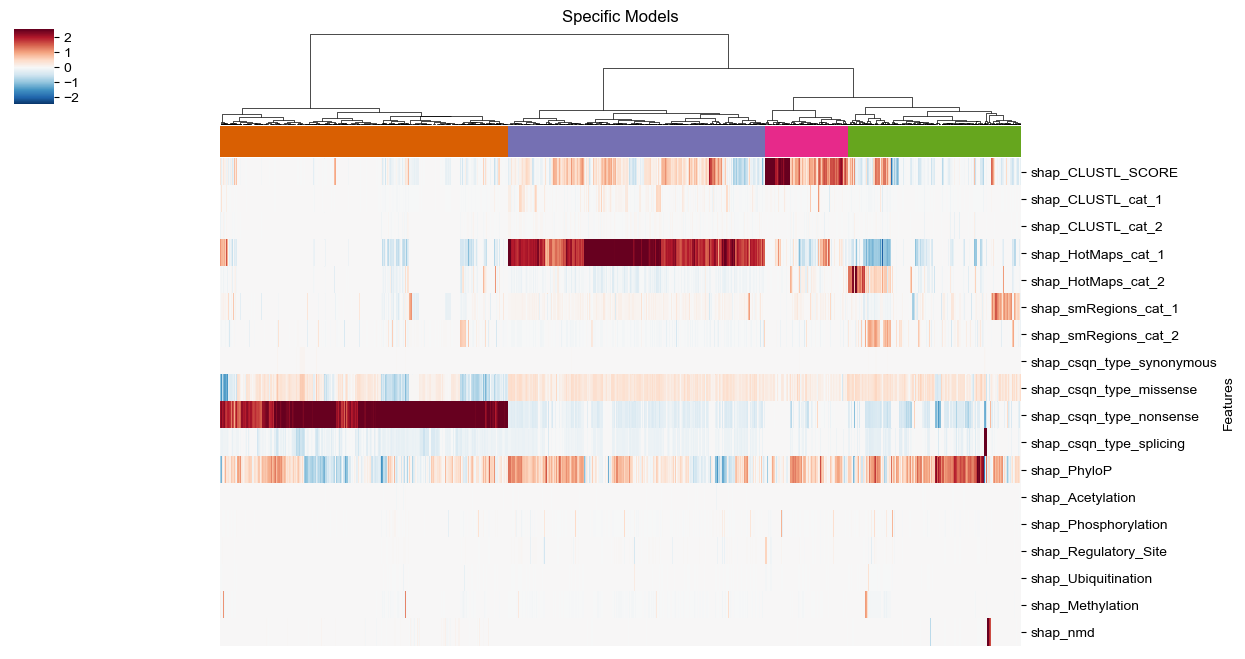

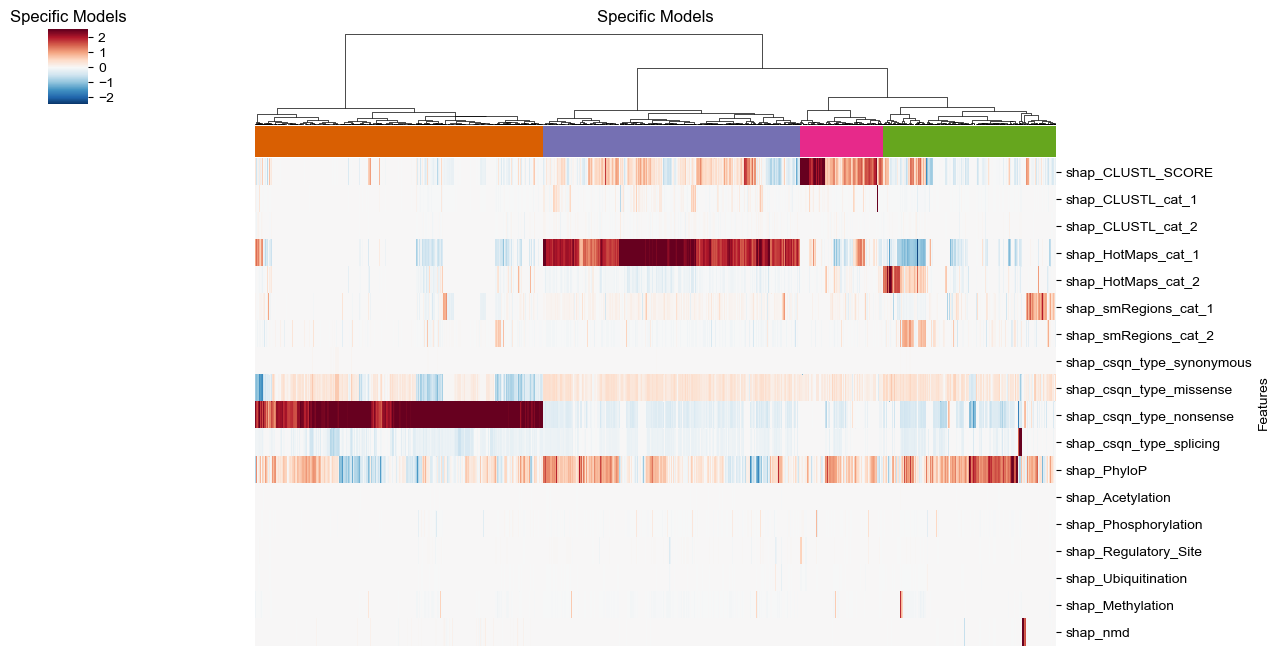

In [12]:
# unique observed mutations 
# per gene-ttype
# covered by specific models 
# with boostDM positive

labels_hierarchical = cluster_heatmap(None, None, mode='flat', 
                                      title='Specific Models', 
                                      fn='observed.specific.driver.hierarchy')

## Step 2: low rank representation

In [40]:
mutation_list = [('RB1', 'E51*', 'BLCA'), 
                 ('PIK3CA', 'E542K', 'BRCA'),
                 ('EGFR', 'L858R', 'LUAD'), 
                 ('KRAS', 'G12D', 'LUAD'), 
                 ('CTNNB1', 'S45P', 'HC'),
                 ('EGFR', 'A289D', 'GBM'),
                 ('TP53', 'K132R', 'LUSC'),
                 ('CIC', 'R202W', 'LGG')]

def index_mutations(df):
    
    zipped = list(zip(df.gene.values, df.aachange.values, df.ttype.values))    
    zipped = [None if z not in mutation_list else ':'.join(z) for z in zipped]
    return zipped
    

def umap_projection(gene, ttype, target):
    
    df = get_shaps(mutations, None, None)
    
    moa_colors = df['moa'].values
    complexity_colors = list(map(cmap, normalize(df['linear_complexity'].values)))
    
    df = df[conf.features]
    lowd = PCA(n_components=10).fit_transform(df)
    standard_embedding = umap.UMAP(n_neighbors=500).fit_transform(lowd, y=target)
    return df, standard_embedding, moa_colors, complexity_colors


def tsne_projection(gene, ttype, target):
    
    df = get_shaps(mutations, None, None)
    zipped = index_mutations(df)
    
    moa_colors = df['moa'].values
    complexity_colors = df['linear_complexity'].values
    
    lowd = PCA(10).fit_transform(df[conf.features])
    tsne = manifold.TSNE(init='pca')
    embedding = tsne.fit_transform(lowd)
    return df, embedding, moa_colors, complexity_colors, zipped


def plot_tsne(projected, zipped, colors, title=None, colorbar=None, fn=None):
    
    fig, ax = plt.subplots(figsize=(5, 5))
    p = ax.scatter(list(projected[:, 0]), list(projected[:, 1]), cmap=cmap, c=colors, alpha=1, s=10)
    
    if colorbar is not None:
        cbar = fig.colorbar(p, ax=ax)
        cbar.ax.set_ylabel(colorbar, rotation=270)
    
    for i, mut in enumerate(zipped):
        if mut is not None:
            ax.text(projected[i,0], projected[i,1], mut)
            ax.scatter([projected[i, 0]], [projected[i, 1]], c='none', alpha=1, s=30, edgecolors='black')
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('t-SNE1')
    ax.set_ylabel('t-SNE2')
    
    if title is not None:
        plt.title(title)
    
    if fn is not None:
        plt.savefig(fn, dpi=300)
    plt.show()

In [26]:
df, projected, moa_colors, complexity_colors, zipped = tsne_projection(None, None, labels_hierarchical)

100%|██████████| 249/249 [02:09<00:00,  2.05it/s]


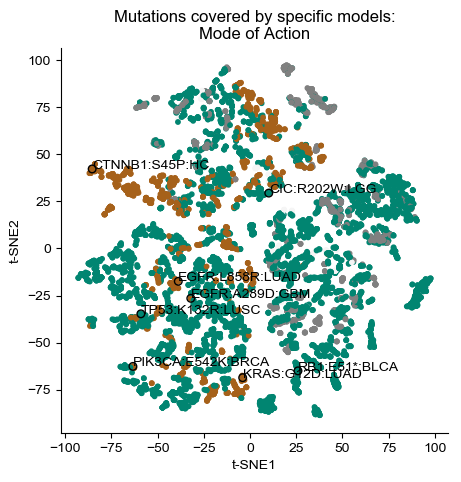

In [41]:
plot_tsne(projected, zipped, moa_colors,
          title='Mutations covered by specific models:\nMode of Action', 
          fn='./raw_plots/unique.boostdm-positive.specific.moa.svg')

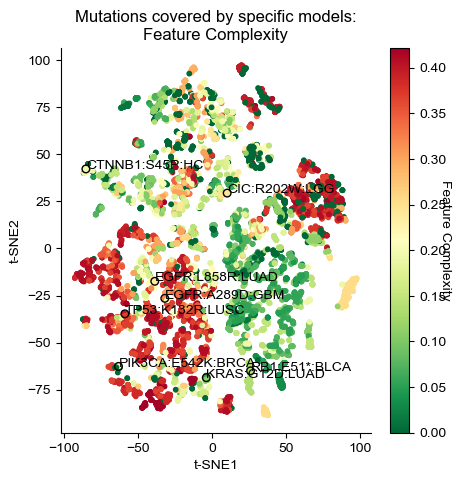

In [42]:
plot_tsne(projected, zipped, complexity_colors, colorbar='Feature Complexity',
          title='Mutations covered by specific models:\nFeature Complexity', 
          fn='unique.boostdm-positive.specific.complexity.svg')

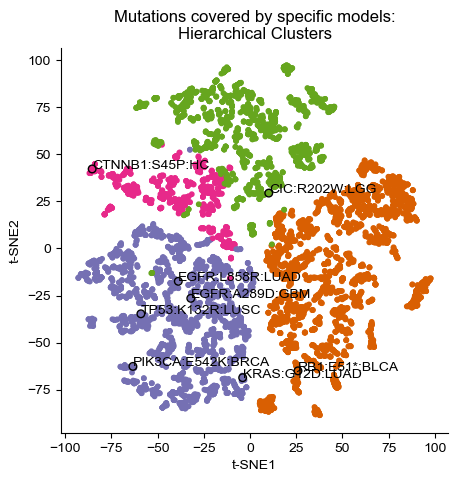

In [43]:
color_list = color_palette('Dark2', 50).as_hex()
kmeans_colors = list(map(lambda s: color_list[s], labels_hierarchical))
plot_tsne(projected, zipped, kmeans_colors, 
              title='Mutations covered by specific models:\nHierarchical Clusters', 
              fn='unique.boostdm-positive.specific.hierarchical.svg')